# Assignment 2
## Question 1: Siamese networks & one-shot learning (7pt)
The Cifar-100 dataset is similar to the Cifar-10 dataset. It also consists of 60,000 32x32 RGB images, but they are distributed over 100 classes instead of 10. Thus, each class has much fewer examples, only 500 training images and 100 testing images per class. For more info about the dataset, see https://www.cs.toronto.edu/~kriz/cifar.html.

*HINT: Import the Cifar-100 dataset directly from Keras, no need to download it from the website. Use* `label_mode="fine"`

### Task 1.1: Siamese network
**a)**
* Train a Siamese Network on the first 80 classes of (the training set of) Cifar-100, i.e. let the network predict the probability that two input images are from the same class. Use 1 as a target for pairs of images from the same class (positive pairs), and 0 for pairs of images from different classes (negative pairs). Randomly select image pairs from Cifar-100, but make sure you train on as many positive pairs as negative pairs.

* Evaluate the performance of the network on 20-way one-shot learning tasks. Do this by generating 250 random tasks and obtain the average accuracy for each evaluation round. Use the remaining 20 classes that were not used for training. The model should perform better than random guessing.

For this question you may ignore the test set of Cifar-100; it suffices to use only the training set and split this, using the first 80 classes for training and the remaining 20 classes for one-shot testing.

*HINT: First sort the data by their labels (see e.g.* `numpy.argsort()`*), then reshape the data to a shape of* `(n_classes, n_examples, width, height, depth)`*, similar to the Omniglot data in Practical 4. It is then easier to split the data by class, and to sample positive and negative images pairs for training the Siamese network.*

*NOTE: do not expect the one-shot accuracy for Cifar-100 to be similar to that accuracy for Omniglot; a lower accuracy can be expected. However, accuracy higher than random guess is certainly achievable.*

In [0]:
import matplotlib.pyplot as plt
from keras.datasets import cifar100
import numpy as np
import pandas as pd
import os
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.utils import to_categorical
from keras import backend as K
from sklearn.utils import shuffle
from scipy.spatial import distance
from keras.layers import Concatenate

C:\Users\20181592\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [0]:
# === add code here ===
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode="fine")

In [0]:
print(x_train.shape)

(50000, 32, 32, 3)


In [0]:
y_train = y_train.flatten()
y_test = y_test.flatten()
print(y_train.shape)
print(y_test.shape)

(50000,)
(10000,)


In [0]:
class_labels = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm']

Class label: lion


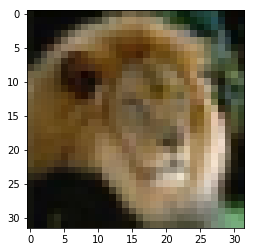

In [0]:
example_id = 14130  # pick any integer from 0 to 49999 to visualize a training example
example = x_train[example_id]
label = y_train[example_id]
print("Class label:", class_labels[label])
plt.imshow(example)
plt.show()

In [0]:
img_rows,img_cols,chns = 32, 32, 3
n_classes = 100

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, chns)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, chns)
input_shape = (img_rows, img_cols, chns)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)


In [0]:
indexes_train = y_train.argsort()
indexes_test = y_test.argsort()
print(indexes_train)
print(indexes_test)

[42957  2126 43210 ... 42095 26322 21122]
[9221 1027 2426 ... 8387 9860 9153]


(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)
Class label: spider


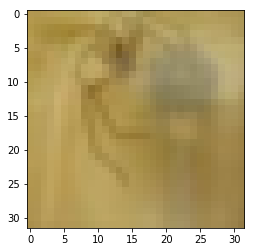

In [0]:
x_train_sort = x_train[indexes_train]
y_train_sort = y_train[indexes_train]

x_test_sort = x_test[indexes_test]
y_test_sort = y_test[indexes_test]

print(x_train_sort.shape)
print(y_train_sort.shape)
print(x_test_sort.shape)
print(y_test_sort.shape)

example_id = 39999  # pick any integer from 0 to 49999 to visualize a training example
example = x_train_sort[example_id]
label = y_train_sort[example_id]
print("Class label:", class_labels[label])
plt.imshow(example)
plt.show()

In [0]:
def group(a, b):
    # Get argsort indices, to be used to sort a and b in the next steps
    sidx = b.argsort(kind='mergesort')
    a_sorted = a[sidx]
    b_sorted = b[sidx]

    # Get the group limit indices (start, stop of groups)
    cut_idx = np.flatnonzero(np.r_[True,b_sorted[1:] != b_sorted[:-1],True])

    # Create cut indices for all unique IDs in b
    n = b_sorted[-1]+2
    cut_idxe = np.full(n, cut_idx[-1], dtype=int)

    insert_idx = b_sorted[cut_idx[:-1]]
    cut_idxe[insert_idx] = cut_idx[:-1]
    cut_idxe = np.minimum.accumulate(cut_idxe[::-1])[::-1]

    # Split input array with those start, stop ones
    out = [a_sorted[i:j] for i,j in zip(cut_idxe[:-1],cut_idxe[1:])]
    return np.array(out)

In [0]:
x_train_shape = group(x_train_sort, y_train_sort)
x_test_shape = group(x_test, y_test)
print(x_train_shape.shape)
print(x_test.shape)

(100, 500, 32, 32, 3)
(10000, 32, 32, 3)


In [0]:
x_train_samples = x_train_shape[:80]
y_train_samples = y_train_sort[:40000]

x_train_rem_samples = x_train_shape[80:]
y_train_rem_samples = y_train_sort[40000:]

print(x_train_samples.shape)
print(y_train_samples.shape)
print(x_train_rem_samples.shape)
print(y_train_rem_samples.shape)

(80, 500, 32, 32, 3)
(40000,)
(20, 500, 32, 32, 3)
(10000,)


In [0]:
input_shape = (32, 32, 3)
left_input = Input(input_shape)
right_input = Input(input_shape)

# build convnet to use in each siamese 'leg'
convnet = Sequential()

convnet.add(Conv2D(64, (3,3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))

convnet.add(Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))

convnet.add(Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(2e-4)))
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))

convnet.add(Conv2D(256, (3,3), activation='relu', kernel_regularizer=l2(2e-4)))
convnet.add(Flatten())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))

convnet.add(Dense(4096, activation="sigmoid", kernel_regularizer=l2(1e-3)))
convnet.summary()

# encode each of the two inputs into a vector with the convnet
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

# merge two encoded inputs with the L1 distance between them, and connect to prediction output layer
L1_distance = lambda x: K.abs(x[0]-x[1])
both = Lambda(L1_distance)([encoded_l, encoded_r])
prediction = Dense(1, activation='sigmoid')(both)
siamese_net = Model(inputs=[left_input,right_input], outputs=prediction)

siamese_net.compile(loss="binary_crossentropy", optimizer="adam")

siamese_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 6, 6, 128)         512       
__________

In [0]:
def get_batch(batch_size, X):
    """Create batch of n pairs, half same class, half different class"""
    n_classes, n_examples, w, h, d = X.shape
    # randomly sample several classes to use in the batch
    categories = np.random.choice(n_classes, size=(batch_size,), replace=False)
    # initialize 2 empty arrays for the input image batch
    pairs = [np.zeros((batch_size, h, w, d)) for i in range(2)]
    # initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
    targets = np.zeros((batch_size,))
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = np.random.randint(0, n_examples)
        pairs[0][i, :, :, :] = X[category, idx_1].reshape(w, h, d)
        idx_2 = np.random.randint(0, n_examples)
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category
        else:
            #add a random number to the category modulo n_classes to ensure 2nd image has different category
            category_2 = (category + np.random.randint(1,n_classes)) % n_classes
        pairs[1][i, :, :, :] = X[category_2,idx_2].reshape(w, h, d)
    return pairs, targets

def batch_generator(batch_size, X):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size, X)
        yield (pairs, targets)

def train(model, X_train, batch_size=64, steps_per_epoch=100, epochs=1):
    model.fit_generator(batch_generator(batch_size, X_train), steps_per_epoch=steps_per_epoch, epochs=epochs)

In [0]:
def make_oneshot_task(N, X, c, language=None):
    """Create pairs of (test image, support set image) with ground truth, for testing N-way one-shot learning."""
    n_classes, n_examples, w, h, d = X.shape
    indices = np.random.randint(0, n_examples, size=(N,))
    if language is not None:
        low, high = c[language]
        if N > high - low:
            raise ValueError("This language ({}) has less than {} letters".format(language, N))
        categories = np.random.choice(range(low,high), size=(N,), replace=False)
    else:  # if no language specified just pick a bunch of random letters
        categories = np.random.choice(range(n_classes), size=(N,), replace=False)            
    true_category = categories[0]
    ex1, ex2 = np.random.choice(n_examples, replace=False, size=(2,))
    test_image = np.asarray([X[true_category, ex1, :, :]]*N).reshape(N, w, h, d)
    support_set = X[categories, indices, :, :]
    support_set[0, :, :] = X[true_category, ex2]
    support_set = support_set.reshape(N, w, h, d)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image, support_set]
    return pairs, targets

def test_oneshot(model, X, c, N=20, k=250, language=None, verbose=True):
    """Test average N-way oneshot learning accuracy of a siamese neural net over k one-shot tasks."""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {}-way one-shot learning tasks ...".format(k, N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N, X, c, language=language)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct += 1
    percent_correct = (100.0*n_correct / k)
    if verbose:
        print("Got an average of {}% accuracy for {}-way one-shot learning".format(percent_correct, N))
    return percent_correct

In [0]:
loops = 10
best_acc = 0
for i in range(loops):
    print("=== Training loop {} ===".format(i+1))
    # Siamese training
    train(siamese_net, x_train_samples)
    # 20 way-one shot learning task
    test_acc = test_oneshot(siamese_net, x_train_rem_samples, y_train_rem_samples)
    if test_acc >= best_acc:
        print("New best one-shot accuracy, saving model ...")
        siamese_net.save(os.path.join("models", "siamese_omniglot.h5"))
        best_acc = test_acc

=== Training loop 1 ===
Epoch 1/1
100/100 [==============================] - 6s 65ms/step - loss: 0.7282: 0s - los
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.0% accuracy for 20-way one-shot learning
New best one-shot accuracy, saving model ...
=== Training loop 2 ===
Epoch 1/1
100/100 [==============================] - 6s 65ms/step - loss: 0.7243
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.0% accuracy for 20-way one-shot learning
New best one-shot accuracy, saving model ...
=== Training loop 3 ===
Epoch 1/1
100/100 [==============================] - 6s 65ms/step - loss: 0.7199: 0s - lo
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 12.8% accuracy for 20-way one-shot learning
New best one-shot accuracy, saving model ...
=== Training loop 4 ===
Epoch 1/1
100/100 [==============================] - 7s 66ms/step - loss: 0.7224
Evaluating model on 250 random 20-way one-sh

***

**b)** Compare the performance of your Siamese network for Cifar-100 to the Siamese network from Practical 4 for Omniglot. Name three fundamental differences between the Cifar-100 and Omniglot datasets. How do these differences influence the difference in one-shot accuracy?

**Answer:**

The performance of Siamese network for Omniglot from Practical 4 achieved an accuracy of 40% whereas the performance of Siamese network for Cifar-100 is around 16%. This difference is caused by:

Omniglot dataset has 1643 classes (964 for training and 659 for testing) with 20 examples per class. Whereas Cifar-100 has 100 classes with 600 examples per class (500 for training and 100 for testing).

Omniglot dataset composed of handwritten symbols. And due to its size of the image (105x105) we use kernel with 10x10 size and this helps in getting the features extracted (the images have clear edges so few features are enough to represent them). The 1st convolution layer returns 6464 features.
Cifar-100 are natural images with shape 32x32x3 (RGB image). They have varying background and most of the image is pixelated thus having noise in it. So, this uses a kernel of size 3x3 so as to not lose the features on the edges and has 1792 features after the 1st convolution layer.

Since Cifar-100 is natural and coloured image it is hard for siamese network to recognize the images in one-shot learning. Its representations are harder and deeper on same image. The same class of image can be represented with different background and in different angle too. So this contributes to various possibility of representing a class and makes it more difficult to identify with high accuracy
Whereas Omniglot dataset is composed of gray scale well defined symbols. The class of a symbol can be represented only in particular angle with few deformations in some images that can be identified with higher accuracy than Cifar-100. Also there is no variation in background thus reducing the region of interest for one-shot learning.

Due to the presence of these significant differences there is difference in their performance.

***

### Task 1.2: One-shot learning with neural codes
**a)**
* Train a CNN classifier on the first 80 classes of Cifar-100. Make sure it achieves at least 40% classification accuracy on those 80 classes (use the test set to validate this accuracy).
* Then use neural codes from one of the later hidden layers of the CNN with L2-distance to evaluate one-shot learning accuracy for the remaining 20 classes of Cifar-100 with 250 random tasks. I.e. for a given one-shot task, obtain neural codes for the test image as well as the support set. Then pick the image from the support set that is closest (in L2-distance) to the test image as your one-shot prediction.

(40000, 32, 32, 3)
(8000, 32, 32, 3)
(40000, 80)
(8000, 80)
Class label: elephant


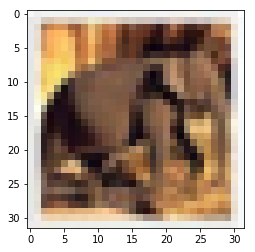

In [0]:
x_training_CNN = x_train_sort[:40000]
y_training = y_train_sort[:40000]
y_training_CNN = to_categorical(y_training, 80)

x_test_CNN = x_test_sort[:8000]
y_test = y_test_sort[:8000]
y_test_CNN = to_categorical(y_test, 80)

print(x_training_CNN.shape)
print(x_test_CNN.shape)
print(y_training_CNN.shape)
print(y_test_CNN.shape)

example_id = 15900  # pick any integer from 0 to 49999 to visualize a training example
example = x_training_CNN[example_id]
label = y_train_sort[example_id]
print("Class label:", class_labels[label])
plt.imshow(example)
plt.show()

In [0]:
# === add code here ===
input_shape = (32, 32, 3)
model = Sequential()
model.add(Conv2D(64,(3,3),activation = 'relu', input_shape = input_shape))
model.add(Conv2D(64,(3,3),activation = 'relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.35))
model.add(Conv2D(128,(3,3),activation = 'relu'))
model.add(Conv2D(128,(3,3),activation = 'relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.35))
model.add(Flatten())
model.add(Dense(512,name = 'hidden_layer', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(80,activation = 'softmax'))
model.summary()

model.compile(optimizer="adadelta", loss="categorical_crossentropy", metrics=["accuracy"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 128)       147584    
__________

In [0]:
batch_size = 100
epochs = 10
print(x_training_CNN.shape)
print(y_training_CNN.shape)
model.fit(x_training_CNN, y_training_CNN,
          batch_size=batch_size,
          epochs=epochs,
          validation_data = (x_test_CNN, y_test_CNN))

(40000, 32, 32, 3)
(40000, 80)
Train on 40000 samples, validate on 8000 samples
Epoch 1/10
40000/40000 [==============================] - 26s 661us/step - loss: 4.0309 - acc: 0.1215 - val_loss: 3.8603 - val_acc: 0.1863
Epoch 2/10
40000/40000 [==============================] - 25s 623us/step - loss: 3.1692 - acc: 0.2293 - val_loss: 3.0266 - val_acc: 0.2815
Epoch 3/10
40000/40000 [==============================] - 25s 622us/step - loss: 2.7898 - acc: 0.2998 - val_loss: 2.7705 - val_acc: 0.3245
Epoch 4/10
40000/40000 [==============================] - 25s 623us/step - loss: 2.5294 - acc: 0.3528 - val_loss: 2.2712 - val_acc: 0.4096
Epoch 5/10
40000/40000 [==============================] - 25s 623us/step - loss: 2.3256 - acc: 0.3948 - val_loss: 2.4311 - val_acc: 0.3920
Epoch 6/10
40000/40000 [==============================] - 25s 624us/step - loss: 2.1858 - acc: 0.4251 - val_loss: 2.1958 - val_acc: 0.4335
Epoch 7/10
40000/40000 [==============================] - 25s 623us/step - loss: 2.082

In [0]:
loss, accuracy = model.evaluate(x_test_CNN, y_test_CNN, verbose=1)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

8000/8000 [==============================] - 2s 245us/step
Test loss: 1.9971144835948944
Test accuracy: 0.477625


In [0]:
neural_codes_model = Model(inputs = model.input, outputs = model.get_layer("hidden_layer").output)
neural_codes_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5_input (InputLayer)  (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 128)       73856     
__________

In [0]:
def make_oneshot_task2(N, X):
    """Create pairs of (test image, support set image) with ground truth, for testing N-way one-shot learning."""
    n_classes, n_examples, w, h, d = X.shape
    indices = np.random.randint(0, n_examples, size=(N,))
    categories = np.random.choice(range(n_classes), size=(N,), replace=False)            
    true_category = categories[0]
    ex1, ex2 = np.random.choice(n_examples, replace=False, size=(2,))
    test_image = np.asarray([X[true_category, ex1, :, :]]*N).reshape(N, w, h, d)
    support_set = X[categories, indices, :, :]
    support_set[0, :, :] = X[true_category, ex2]
    support_set = support_set.reshape(N, w, h, d)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    #pairs = [test_image, support_set]
    return test_image, support_set, targets

In [0]:
# One shot learning
N=20
n_correct = 0
k=250

for _ in range(0,250):
    test_image, support_set, targets = make_oneshot_task2(N,x_train_rem_samples)
    test_image_pred = neural_codes_model.predict(test_image)
    support_set_pred = neural_codes_model.predict(support_set)
    distances = []

    for i in range(0,20):
        dist = distance.euclidean(test_image_pred[i],support_set_pred[i])
        distances.append(dist)
    if np.argmin(distances) == np.argmax(targets):
        n_correct += 1
accuracy = (100.0*n_correct / k)
print("Got an average of {}% accuracy for {}-way one-shot learning".format(accuracy, N))

Got an average of 18.4% accuracy for 20-way one-shot learning


***

**b)** Briefly motivate your CNN architecture, and discuss the difference in one-shot accuracy between the Siamese network approach and the CNN neural codes approach.

**Answer:**

Initially we set the feature for convolution layers as 32, 64 and 128 and a Dropout of 0.2 to 0.5 was tried but could not achieve good accuracy. Then a conclusion was drawn that the features were not enough for it to train on. So started with 64 and 128 features in convolution layers so as to extract enough features. The maxpooling layer was added and dropouts were chosen to be 0.35 (except last layer) to avoid overfitting and also to reduce the density of the network. BatchNormalization was done in between these steps to normalize the output to increase the training speed. The hidden layer is fully connected dense layer with 512 neurons and last layer with 80 neurons for 80 output classes. The dropout is 0.5 so as to avoid overfitting and to remove the similar neurons. The activation is softmax as we need to perform classification. The optimizer adadelta continuously learns and is most suitable for classification tasks, it also works good for sparse networks. Trying with 10 epoch the model achieved an accuracy of 53% whereas with 30 epochs the model achieved an accuracy 56%. This result is due to extensive training of the model with more iterations.

Siamese network achieved an accuracy of 16%. This network compares 2 images, their distances and concludes if they are from same class or not. Whereas the CNN uses L2 distance metric to measure the distance between embeddings 

***
## Question 2: Triplet networks & one-shot learning (10pt)

### Task 2.1: Train a triplet network
**a)**
* Train a triplet network on the first 80 classes of (the training set of) Cifar-100.
 
* Make sure the network achieves a smaller loss than the margin and the network does not collapse all representations to zero vectors. *HINT: If you experience problems to achieve this goal, it might be helpful to tinker the learning rate.*

* You are provided with a working example of triplet loss implementation for Keras below. You may directly use it.

You may ignore the test set of Cifar-100 for this question as well. It suffices to use only the training set and split this, using the first 80 classes for training and the remaining 20 classes for one-shot testing.

```python
# Notice that ground truth variable is not used for loss calculation. It is used as a function argument to by-pass some Keras functionality. This is because the network structure already implies the ground truth for the anchor image with the "positive" image.
import tensorflow as tf
def triplet_loss(ground_truth, network_output):

    anchor, positive, negative = tf.split(network_output, num_or_size_splits=3, axis=1)        
    
    for embedding in [anchor, positive, negative]:
        embedding = tf.math.l2_normalize(embedding)

    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=1)
    
    margin = # define your margin
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), margin)
    loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0), axis=0)

    return loss
```


In [0]:
import tensorflow as tf
def triplet_loss(ground_truth, network_output):

    anchor, positive, negative = tf.split(network_output, num_or_size_splits=3, axis=1)        

    for embedding in [anchor, positive, negative]:
        embedding = tf.math.l2_normalize(embedding)

    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=1)

    margin = 0.15 # define your margin
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), margin)
    loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0), axis=0)

    return loss

In [0]:
input_shape = (32, 32, 3)
anchor_input = Input(input_shape)
npositive_input = Input(input_shape)
negative_input = Input(input_shape)

# build convnet to use in each siamese 'leg'
convnet_triplet = Sequential()

convnet_triplet.add(Conv2D(64, (3,3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(2e-4)))
convnet_triplet.add(MaxPooling2D())
convnet_triplet.add(BatchNormalization())
convnet_triplet.add(Dropout(0.25))

convnet_triplet.add(Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(2e-4)))
convnet_triplet.add(MaxPooling2D())
convnet_triplet.add(BatchNormalization())
convnet_triplet.add(Dropout(0.25))

convnet_triplet.add(Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(2e-4)))
convnet_triplet.add(BatchNormalization())
convnet_triplet.add(Dropout(0.25))

convnet_triplet.add(Conv2D(256, (3,3), activation='relu', kernel_regularizer=l2(2e-4)))
convnet_triplet.add(Flatten())
convnet_triplet.add(BatchNormalization())
convnet_triplet.add(Dropout(0.25))

convnet_triplet.add(Dense(2048, activation="sigmoid", name="hidden_layer", kernel_regularizer=l2(1e-3)))
convnet_triplet.summary()

# encode each of the two inputs into a vector with the convnet
encoded_anchor = convnet_triplet(anchor_input)
encoded_positive = convnet_triplet(positive_input)
encoded_negative = convnet_triplet(negative_input)

# merge two encoded inputs with the L1 distance between them, and connect to prediction output layer
# L2_distance = lambda x: K.abs(x[0]-x[1])

# all_three = Lambda(L2_distance)([encoded_anchor, encoded_positive, encoded_negative])
# prediction_t = Dense(1, activation='sigmoid')(all_three)

merged_vector = Concatenate(axis=-1)([encoded_anchor, encoded_positive, encoded_negative])
# prediction_t = Dense(6561, activation="sigmoid", kernel_regularizer=l2(1e-3))(merged_vector)
triplet_net = Model(inputs=[anchor_input, positive_input ,negative_input], outputs=merged_vector)
# triplet_net = Model(inputs=[anchor_input, positive_input ,negative_input])
# triplet_net.add(prediction_t)


triplet_net.compile(loss=triplet_loss, optimizer=keras.optimizers.Adadelta(1.2))

triplet_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_89 (Conv2D)           (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
batch_normalization_86 (Batc (None, 15, 15, 64)        256       
_________________________________________________________________
dropout_87 (Dropout)         (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 13, 13, 128)       73856     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
batch_normalization_87 (Batc (None, 6, 6, 128)         512       
__________

In [0]:
def get_triplets(batch_size, X):
    """Create batch of n triplets, half same class, half different class"""
    n_classes, n_examples, w, h, d = X.shape

    categories = np.random.choice(n_classes, size=(batch_size,), replace=False)
    triplets = [np.zeros((batch_size, h, w, d)) for i in range(3)]
    targets = np.zeros((batch_size,))
    for i in range(batch_size):
        category = categories[i]
        idx_1 = np.random.randint(0, n_examples)
        triplets[0][i, :, :, :] = X[category, idx_1].reshape(w, h, d)
        idx_2 = np.random.randint(0, n_examples)
        triplets[1][i, :, :, :] = X[category, idx_2].reshape(w, h, d)
        idx_3 = np.random.randint(0, n_examples)
        category_2 = (category + np.random.randint(1,n_classes)) % n_classes
        triplets[2][i, :, :, :] = X[category_2, idx_3].reshape(w, h, d)
    return triplets, targets

def triplet_generator(batch_size, X):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        triplets, targets = get_triplets(batch_size, X)
        yield (triplets, targets)

def train_triplet_network(model, X_train, batch_size=64, steps_per_epoch=100, epochs=40):
    model.fit_generator(triplet_generator(batch_size, X_train), steps_per_epoch=steps_per_epoch, epochs=epochs)
        

In [0]:
# Data for triplet

x_training_triplet = x_train_samples
y_training_triplet = y_train_samples

print(x_training_triplet.shape)
print(y_training_triplet.shape)

x_test_triplet = x_train_rem_samples
y_test_triplet = y_train_rem_samples

print(x_test_triplet.shape)
print(y_test_triplet.shape)


(80, 500, 32, 32, 3)
(40000,)
(20, 500, 32, 32, 3)
(10000,)


In [0]:
train_triplet_network(triplet_net, x_training_triplet, epochs=60)

Epoch 1/60
100/100 [==============================] - 15s 153ms/step - loss: 12.8759
Epoch 2/60
100/100 [==============================] - 3s 31ms/step - loss: 12.4111
Epoch 3/60
100/100 [==============================] - 3s 31ms/step - loss: 11.2317
Epoch 4/60
100/100 [==============================] - 3s 30ms/step - loss: 10.8129
Epoch 5/60
100/100 [==============================] - 3s 29ms/step - loss: 10.4428
Epoch 6/60
100/100 [==============================] - 3s 29ms/step - loss: 10.1816
Epoch 7/60
100/100 [==============================] - 3s 29ms/step - loss: 9.4674
Epoch 8/60
100/100 [==============================] - 3s 29ms/step - loss: 9.0689
Epoch 9/60
100/100 [==============================] - 3s 29ms/step - loss: 8.6481
Epoch 10/60
100/100 [==============================] - 3s 29ms/step - loss: 7.7313
Epoch 11/60
100/100 [==============================] - 3s 29ms/step - loss: 6.8906
Epoch 12/60
100/100 [==============================] - 3s 29ms/step - loss: 5.3226
Epoch

***

### Task 2.2: One-shot learning with triplet neural codes
**a)**
* Use neural codes from the triplet network with L2-distance to evaluate one-shot learning accuracy for the remaining 20 classes of Cifar-100 with 250 random tasks. I.e. for a given one-shot task, obtain neural codes for the test image as well as the support set. Then pick the image from the support set that is closest (in L2-distance) to the test image as your one-shot prediction.
* Explicitly state the accuracy.

In [0]:
def make_oneshot_task_triplet(N, X, c, language=None):
    """Create pairs of (test image, support set image) with ground truth, for testing N-way one-shot learning."""
    n_classes, n_examples, w, h, d = X.shape
    
    indices = np.random.randint(0, n_examples, size=(N,))
#     print
    categories = np.random.choice(range(n_classes), size=(N,), replace=False)            
    
    true_category = categories[0]
    
    ex1, ex2 = np.random.choice(n_examples, replace=False, size=(2,))
    
    test_image = np.asarray([X[true_category, ex1, :, :]]*N).reshape(N, w, h, d)
    
    negative_set = X[categories, indices, :, :]
#     support_set = X[categories, indices, :, :]
#     positive_set = np.zeros((categories,indices,))
    positive_set = np.asarray([X[true_category, ex2, :, :]]*N).reshape(N, w, h, d)
    negative_set = negative_set.reshape(N, w, h, d)
    targets = np.zeros((N,))
    test_image, positive_set, negative_set = shuffle(test_image, positive_set, negative_set)
    triplets = (test_image, positive_set, negative_set)
    triplets = list(triplets)
    return triplets

def test_oneshot_triplet(model, X, c, N=20, k=250, language=None, verbose=True):
    """Test average N-way oneshot learning accuracy of a siamese neural net over k one-shot tasks."""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {}-way one-shot learning tasks ...".format(k, N))
    for i in range(k):
        
        triplets = make_oneshot_task_triplet(N, X, c, language=language)
        probs = model.predict(triplets)
        
        loss = check_triple_net_loss(probs)
        if loss > 0 :
            n_correct +=1
    percent_correct = (100.0*n_correct / k)
    if verbose:
        print("Got an average of {}% accuracy for {}-way one-shot learning".format(percent_correct, N))
    return percent_correct


def check_triple_net_loss(probs):
    anchor, positive, negative = tf.split(probs, num_or_size_splits=3, axis=1)        

    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=1)

    actual_loss= tf.reduce_sum(tf.subtract(pos_dist,neg_dist)).eval(session = sess)
    return actual_loss

In [0]:
sess = tf.Session()
sess.as_default()

test_oneshot_triplet(triplet_net, x_test_triplet, [], N = 20)


Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 16.8% accuracy for 20-way one-shot learning


16.8

***
## Question 3: Performance comparison (3pt)


**a)** What accuracy would random guessing achieve (on average) on this dataset? Motivate your answer briefly.

On random guessing this data set would achieve (100/n_classes)% accuracy. Here we do it for 20 classes so 5% is the accuracy that will be achieved for random guessing.



**b)** Discuss and compare the performances of networks in tasks 1.1, 1.2 and 2.2. Briefly motivate and explain which task would be expected the highest accuracy. Explain the reasons of the accuracy difference if there are any. If there is almost no difference accuracy, explain the reason for that.

The performance of the tasks vary for all the three questions. Q1.1 gives an accuracy of around 15%, Q1.2 gives an accuracy of around 48% and Q2.2 gives an accuracy of  16.8%. In 1.1 and 2.2 we compare the similarity between images with respect to their distances and say if they are from same class or not. Since it is colour image with varying background and has some noise in it, similarity calculation of final image performs poorly but 1.2 calculates the distance between the two images with help of the embedding matrix and says if it is from similar class or not. This variation of metric costs big and thus affect the performance.

***
## Question 4: Peer review (0pt)

Finally, each group member must write a single paragraph outlining their opinion on the work distribution within the group. Did every group member contribute equally? Did you split up tasks in a fair manner, or jointly worked through the exercises. Do you think that some members of your group deserve a different grade from others?

*=== write your answer here ===*